In [2]:
%matplotlib -l

Available matplotlib backends: ['osx', 'qt4', 'qt5', 'gtk3', 'notebook', 'wx', 'qt', 'nbagg', 'gtk', 'tk', 'inline']


In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import pyshtools as sht
import numpy as np
from scipy.special import erfi
import MapDrawer as MD
plt.rcParams['figure.figsize'] = [12.0,8.0]

Loading SHTOOLS documentation


In [2]:
# These are in the "geodesy" normalization convention: the SHTools default (norm=1)
max_degree = 2190
#max_degree = 2159
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',max_degree)

In [3]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [4]:
potential = sht.MakeGridDH(coeffs,sampling=2,csphase=1)
md.DrawMap(potential,lon_0=180)

NameError: name 'md' is not defined

In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=2)

In [131]:
reload(MD)

<module 'MapDrawer' from 'MapDrawer.py'>

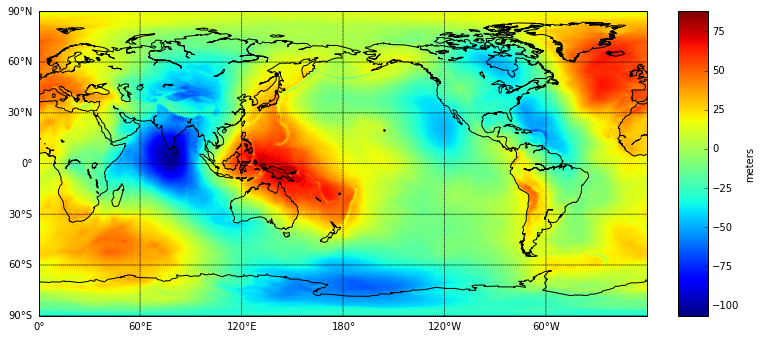

In [5]:
md = MD.MapDrawer('cyl',geoid)
md.DrawMap(geoid,lon_0=180,units_label='meters')

4382 8764


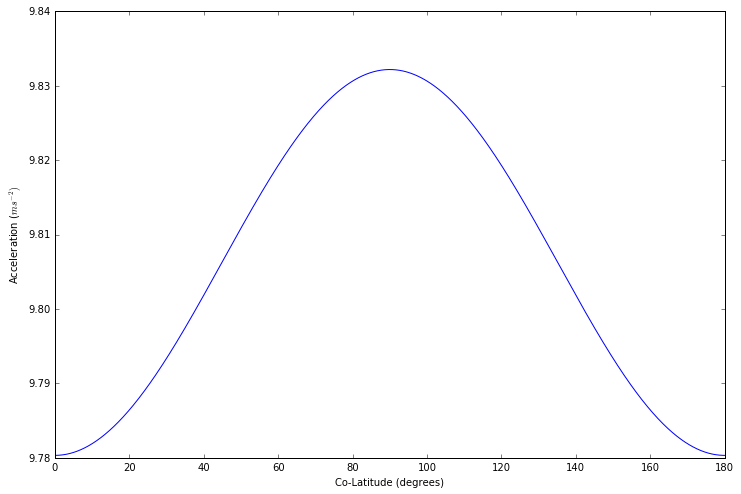

In [6]:
nlat,nlon = geoid.shape
print nlat, nlon
dlat = 180. / nlat
lats = np.linspace(0. + (dlat / 2.), 180. - (dlat / 2.), nlat)
#plt.plot(lats)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
plt.plot(lats,ng)
plt.ylabel('Acceleration ($m s^{-2})$')
plt.xlabel('Co-Latitude (degrees)')
#print normal_gravs

-1046.80278545 863.028452941


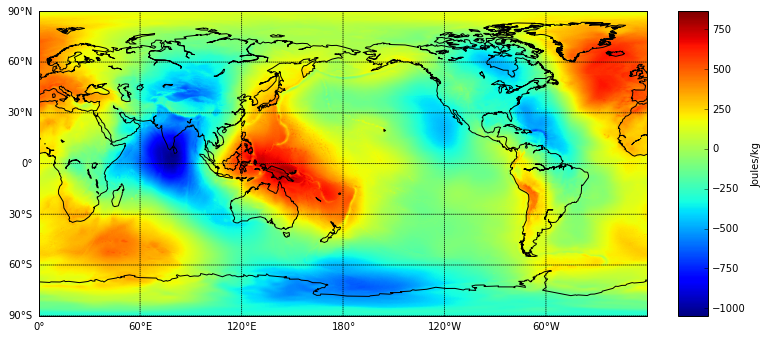

In [7]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
md.DrawMap(T,units_label='Joules/kg')
#fig.savefig('Timage.png')
print T.min(),T.max()

In [8]:
# In order to exactly match the Driscoll-Healy convolution theorem details, 
# we'll use the ortho-normalized (norm=4) version, with CS phase...
# DON'T FORGET TO CALL WITH SAMPLING=2  !!!!!!!!
T_SH = sht.SHExpandDH(T, lmax_calc=max_degree,norm=4,sampling=2,csphase=-1)

-1046.80278108 863.029327089


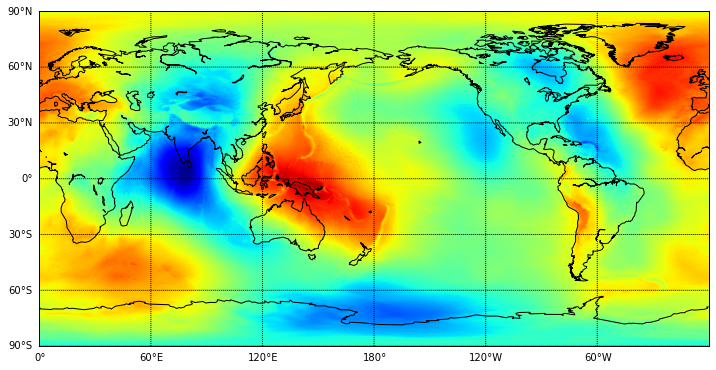

In [9]:
# Sanity check: Do we reproduce T as a grid from the T_SH coefficients?
T_test = sht.MakeGridDH(T_SH,sampling=2,csphase=-1,norm=4)
md.DrawMap(T_test)
print T_test.min(),T_test.max()

In [10]:
T_err = T-T_test
#plt.imshow(np.arcsinh(T_err))
print T_err.min(),T_err.max()

-0.00493284119167 0.00373991565952


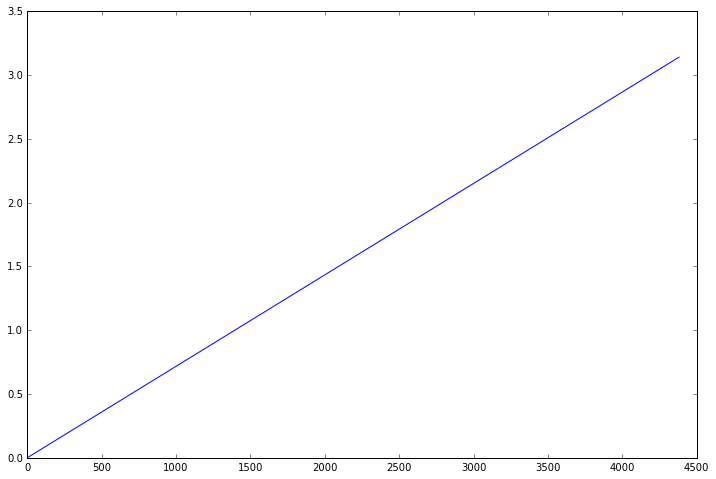

In [9]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True,dtype=np.double)
plt.plot(co_lats)

In [20]:
r_inner = 6371000. - 10000.
# r_inner = 0.5290 *6371000.
#rpm_2D = -make_Rpm(R_e = 6371000., r_i = r_inner, co_lats = co_lats, shp = T.shape)
print 6371000. - r_inner

10000.0


According to Arfken and Weber (4th International edition, 1995; eqn. 12.3) the Legendre polynomial $P_n(\cos \theta)$ coefficient of 1/r is $\left( \frac{a}{r} \right)^n$, where $a$ is the radius of the inner sphere, and $r$ is the radius of the outer sphere. Let's plot those coefficients and see what the look like relative to the stuff we've been evaluating numerically. In our notation, $r$ is $R_e$, while $a$ is $r_i$, so the expression becomes $\left( \frac{r_i}{R_e} \right)^n$.

In [21]:
P_degrees = np.arange(0,max_degree+1,1.)
print len(P_degrees)
# This is the expression for the 1/r_{12} Operator
P_coeffs = np.sqrt((4.*np.pi)/((2*P_degrees)+1.))*(r_inner/6371000.)**(P_degrees) 
print(len(P_coeffs))

2191
2191


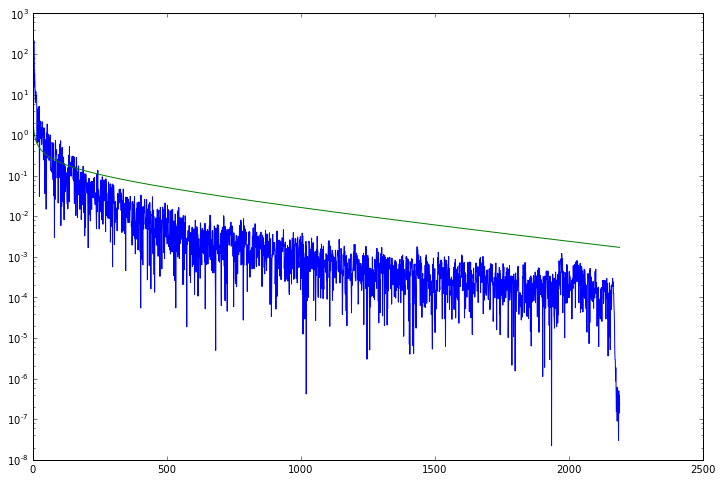

In [22]:
plt.semilogy(np.abs(T_SH[0,:,0]))
plt.semilogy(P_coeffs)
#plt.semilogy(np.abs(1./kernel))
#plt.semilogy(np.abs(1./(kernel**2)))


In [13]:
# We need to fully populate the array in memory otherwise the fortran code barfs...
forward_op_SH = np.zeros_like(T_SH)
forward_op_SH[:,:,0] = P_coeffs[np.newaxis,:]
inverse_op_SH = np.zeros_like(T_SH)
inverse_op_SH[:,:,0] = 1./P_coeffs[np.newaxis,:]
print(forward_op_SH.shape)
inv_distance = sht.MakeGridDH(forward_op_SH,sampling=2,csphase=-1,norm=4)
print(inv_distance.max(),inv_distance.min())

(2, 2191, 2191)
(212.35981398049438, 0.50117519594790505)


In [ ]:
print inv_distance[:500,100]

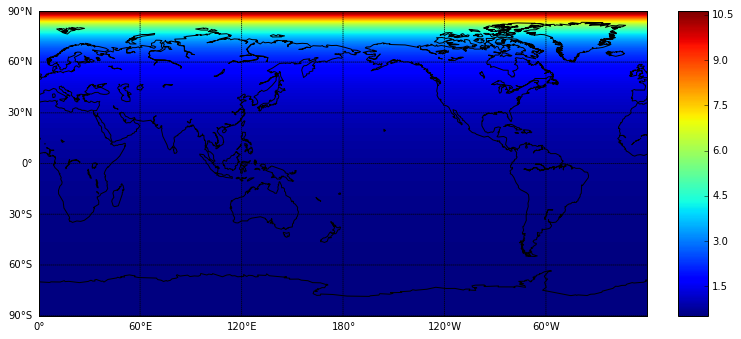

In [155]:
md.DrawMap(inv_distance)

In [14]:
sh_degree = np.arange(T_SH.shape[1])
factor = 2.*np.pi*np.sqrt((4.*np.pi)/(1+(2*sh_degree)))
#print factor.shape, inverse_op_SH.shape
BP_op_deg_0 = forward_op_SH[:,:,0]*factor[np.newaxis,:]
BP_SH = BP_op_deg_0[:,:,np.newaxis] * T_SH

K_op_deg_0 = 1.0/((forward_op_SH*forward_op_SH)[:,:,0])*factor[np.newaxis,:]
FBP_SH = BP_op_deg_0[:,:,np.newaxis]*K_op_deg_0[:,:,np.newaxis] * T_SH
#print  FBP_SH.shape

In [90]:
print zonal_op_deg_0.shape

(2, 2191)


In [15]:
BP_30 = sht.MakeGridDH(BP_SH,sampling=2,csphase=-1,norm=4)
FBP_30 = sht.MakeGridDH(FBP_SH,sampling=2,csphase=-1,norm=4)

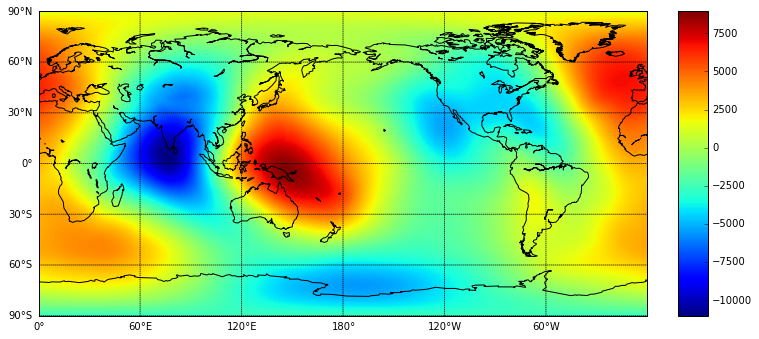

In [185]:
#BP_50_clipped = np.arcsinh(BP_50)
md.DrawMap(BP_10)


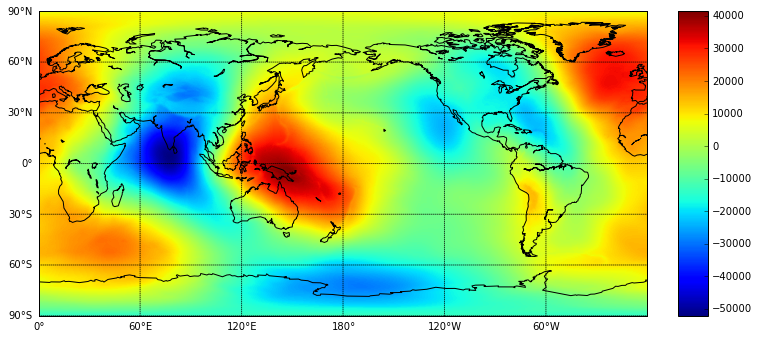

In [187]:
md.DrawMap(FBP_10)
#md.DrawMap(FBP_50)

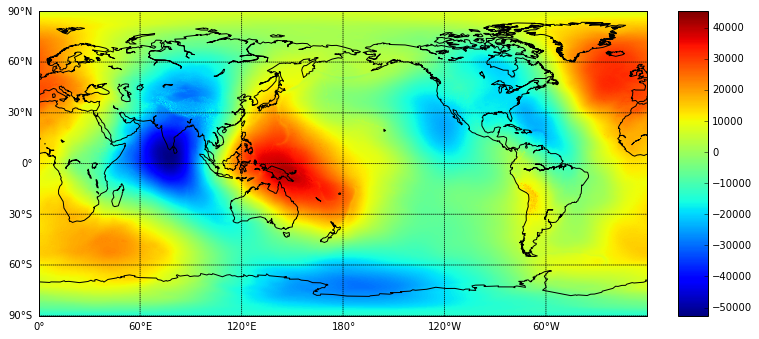

In [195]:
md.DrawMap(FBP_20)


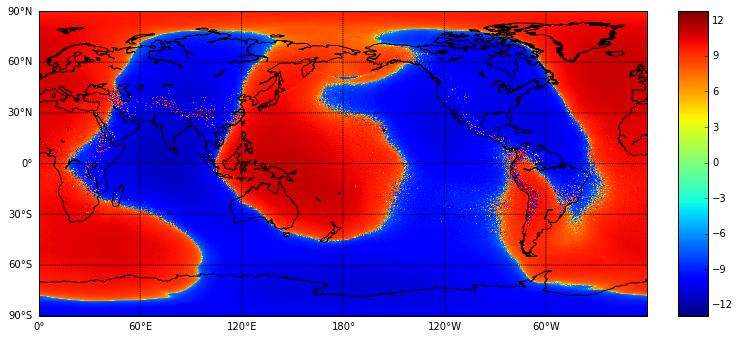

In [16]:
md.DrawMap(np.arcsinh(FBP_30))


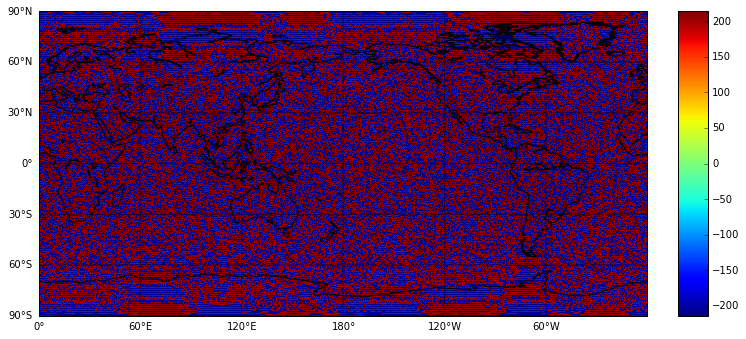

In [170]:
md.DrawMap(np.arcsinh(FBP_600))


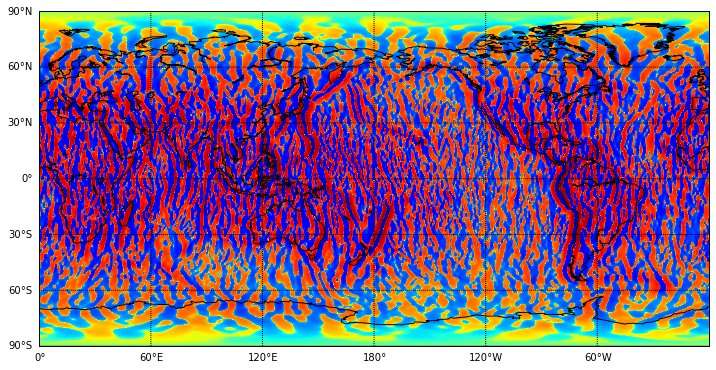

In [71]:
FBP_200_clipped = np.arcsinh(FBP_200)
md.DrawMap(FBP_200_clipped)

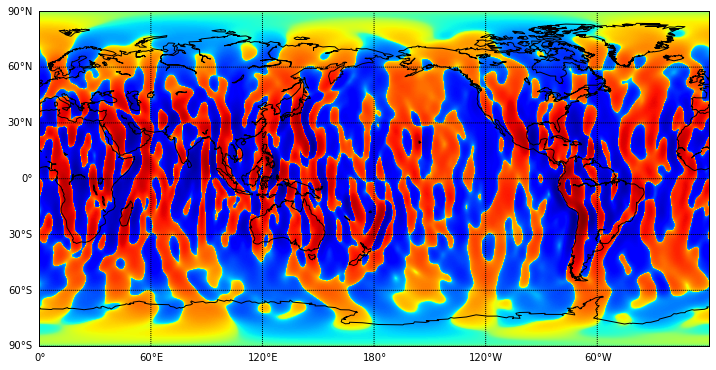

In [83]:
FBP_600_clipped = np.arcsinh(FBP_600)
md.DrawMap(FBP_600_clipped)

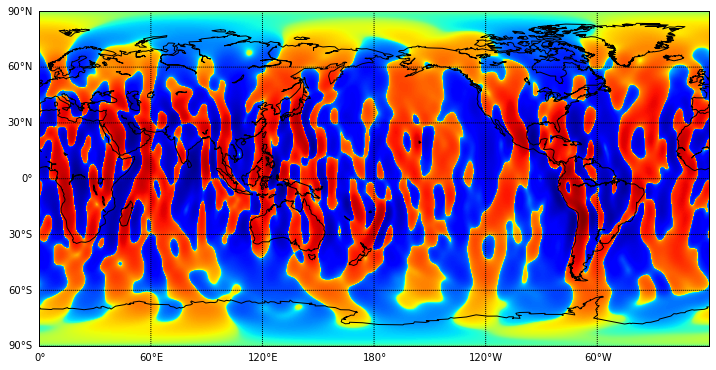

In [77]:
FBP_700_clipped = np.arcsinh(FBP_700)
md.DrawMap(FBP_700_clipped)

In [56]:
filtered_convolved = convolved.copy()
filtered_convolved[0,:,:] *= K_filter_clipped[ :, np.newaxis]
filtered_convolved[1,:,:] *= K_filter_clipped[ :, np.newaxis]

In [26]:
tomo_d50_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [57]:
tomo_d100_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [52]:
tomo_d660_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [116]:
tomo_d2880_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [22]:
tomo_d3000_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [ ]:
plt.hist(tomo_d100_filtered.flat,bins=100,log=True)

-1.08866577277 1.02811638317


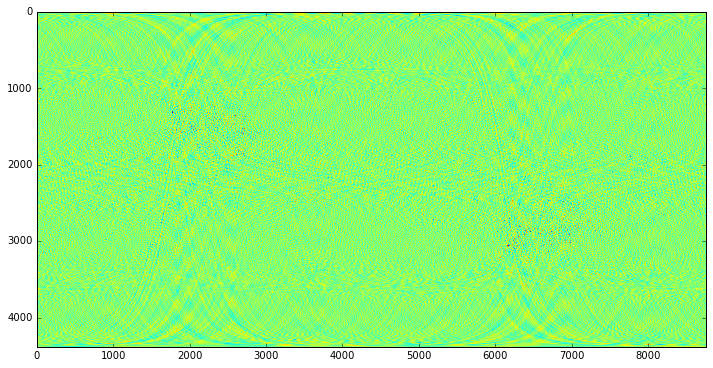

In [28]:
plt.imshow(tomo_d50_filtered)
print tomo_d50_filtered.min(),tomo_d50_filtered.max()

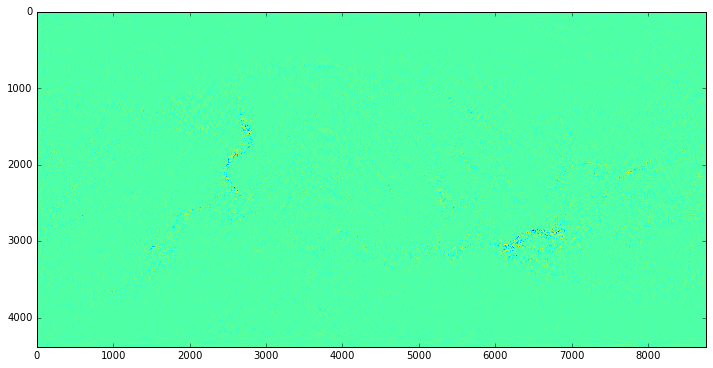

In [58]:
plt.imshow(tomo_d100_filtered)

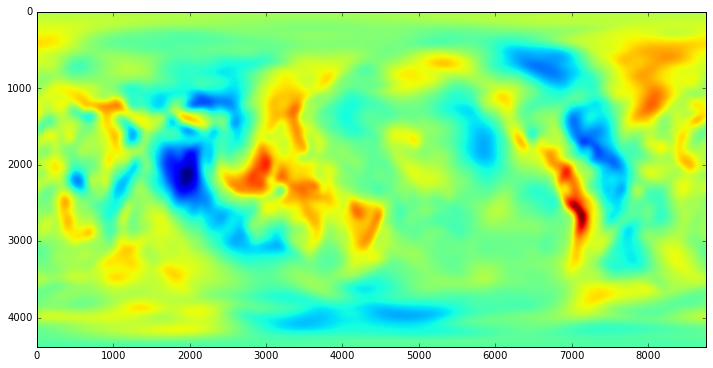

In [53]:
plt.imshow(tomo_d660_filtered)

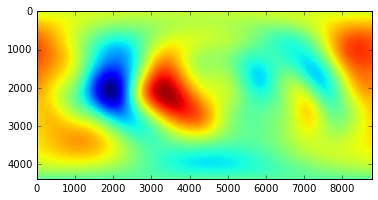

In [117]:
plt.imshow(tomo_d2880_filtered)

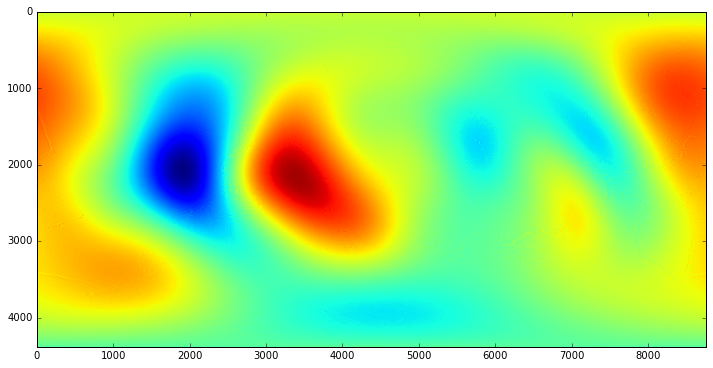

In [27]:
plt.imshow(tomo_d3000_filtered)

In [1]:
%matplotlib inline
%run GravTomo.py

Loading SHTOOLS documentation




**Old dead code only below here. Mostly preserved for examples of calling routines...**

In [35]:
#d_dr_op = -(2. + np.arange(0,kernel.shape[0]))/(r_inner)
d_dr_op = -(1. + np.arange(1.,kernel.shape[0]+1))/(r_inner)

-0.0429923661583


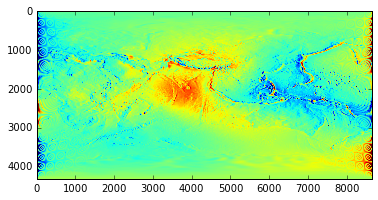

In [36]:
grav_disturbance_SH = d_dr_op * T_SH
grav_disturbance = sht.MakeGridDH(grav_disturbance_SH,sampling=2,csphase=1)
plt.imshow(grav_disturbance,vmin=-0.001,vmax=0.001)
print grav_disturbance.min()

In [23]:
d_dr_convolved = d_dr_op[np.newaxis,:,np.newaxis] * convolved * cone_filter_2d

In [24]:
d_dr_2D = sht.MakeGridDH(d_dr_convolved,sampling=2,csphase=1)

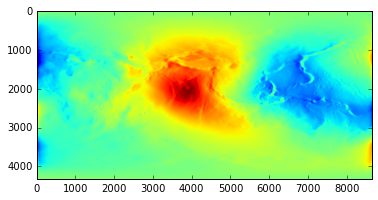

In [25]:
plt.imshow(d_dr_2D)